In [40]:
# 1. Импорты 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay

# Фиксируем случайность для воспроизводимости
RANDOM_STATE = 42

In [31]:
# 2. Загрузка данных 
df = pd.read_csv("../../seminars/S05/S05-hw-dataset.csv")

In [41]:
# 3. Первичный анализ данных 
print("Первые 5 строк:")
display(df.head())

print("\nИнформация о данных:")
df.info()

print("\nОписательные статистики:")
display(df.describe())

print("\nРаспределение целевой переменной (default):")
display(df["default"].value_counts(normalize=True))

print('Датасет содержит 3000 объектов и 16 признаков (плюс технический client_id). Все признаки числовые, пропусков нет. Значения выглядят правдоподобно: возраст от 21 до 69 лет, доход от 15 000 до 156 351, debt_to_income в пределах [0, ~0.88], балансы могут быть отрицательными — всё соответствует описанию. Целевой признак default умеренно несбалансирован: ~59% клиентов без дефолта (0) и ~41% — с дефолтом (1). Явных аномалий не наблюдается.')


Первые 5 строк:


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000



Распределение целевой переменной (default):


default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

Датасет содержит 3000 объектов и 16 признаков (плюс технический client_id). Все признаки числовые, пропусков нет. Значения выглядят правдоподобно: возраст от 21 до 69 лет, доход от 15 000 до 156 351, debt_to_income в пределах [0, ~0.88], балансы могут быть отрицательными — всё соответствует описанию. Целевой признак default умеренно несбалансирован: ~59% клиентов без дефолта (0) и ~41% — с дефолтом (1). Явных аномалий не наблюдается.


In [34]:
# 4. Подготовка признаков и таргета 
X = df.drop(columns=["client_id", "default"])
y = df["default"]


In [35]:
# 5. Разделение на train и test 
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print(f"\nРазмеры выборок:")
print(f"  Train: {X_train.shape[0]} объектов")
print(f"  Test:  {X_test.shape[0]} объектов")



Размеры выборок:
  Train: 2400 объектов
  Test:  600 объектов


In [36]:
#  6. Бейзлайн: DummyClassifier 
print("\n Бейзлайн (DummyClassifier, strategy='most_frequent') ")

dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)

# Предсказания и метрики
y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

acc_dummy = accuracy_score(y_test, y_pred_dummy)
auc_dummy = roc_auc_score(y_test, y_proba_dummy)

print(f"Accuracy : {acc_dummy:.4f}")
print(f"ROC-AUC  : {auc_dummy:.4f}")



 Бейзлайн (DummyClassifier, strategy='most_frequent') 
Accuracy : 0.5900
ROC-AUC  : 0.5000


In [37]:

# 7. Логистическая регрессия с подбором C
print("\n Логистическая регрессия (подбор C через GridSearchCV) ")

# Создаём pipeline: масштабирование + логистическая регрессия
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

# Сетка значений C
param_grid = {"logreg__C": [0.01, 0.1, 1.0, 10.0]}

# Подбор по ROC-AUC с 5-фолдовой кросс-валидацией
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

# Обучение на train
grid_search.fit(X_train, y_train)

print(f"Лучший C        : {grid_search.best_params_['logreg__C']}")
print(f"Лучший ROC-AUC (на CV): {grid_search.best_score_:.4f}")



 Логистическая регрессия (подбор C через GridSearchCV) 
Лучший C        : 10.0
Лучший ROC-AUC (на CV): 0.8607


In [44]:
# 8. Оценка на тестовой выборке 
best_model = grid_search.best_estimator_

y_pred_lr = best_model.predict(X_test)
y_proba_lr = best_model.predict_proba(X_test)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

print(f"\n Итоговая оценка на TEST ")
print(f"DummyClassifier → Accuracy: {acc_dummy:.4f}, ROC-AUC: {auc_dummy:.4f}")
print(f"LogisticRegression → Accuracy: {acc_lr:.4f}, ROC-AUC: {auc_lr:.4f}")

print('Бейзлайн DummyClassifier (всегда предсказывает 0) достиг accuracy ≈ 0.59 и ROC-AUC ≈ 0.50, что соответствует случайному угадыванию. Логистическая регрессия с лучшим C = 10.0 показала значительно лучшее качество ROC-AUC ≈ {0.8607}. Это подтверждает, что модель действительно учится выявлять риск дефолта. Наилучший C указывает на удачный баланс между сложностью и обобщающей способностью. Логистическая регрессия — разумный выбор для этой задачи: она проста, интерпретируема и эффективна.')


 Итоговая оценка на TEST 
DummyClassifier → Accuracy: 0.5900, ROC-AUC: 0.5000
LogisticRegression → Accuracy: 0.8000, ROC-AUC: 0.8756
Бейзлайн DummyClassifier (всегда предсказывает 0) достиг accuracy ≈ 0.59 и ROC-AUC ≈ 0.50, что соответствует случайному угадыванию. Логистическая регрессия с лучшим C = 10.0 показала значительно лучшее качество ROC-AUC ≈ {0.8607}. Это подтверждает, что модель действительно учится выявлять риск дефолта. Наилучший C указывает на удачный баланс между сложностью и обобщающей способностью. Логистическая регрессия — разумный выбор для этой задачи: она проста, интерпретируема и эффективна.


<Figure size 700x500 with 0 Axes>

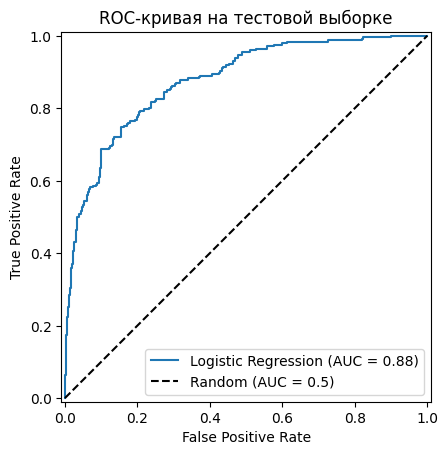

In [51]:
# 9. Сохранение ROC-кривой 
# Убедимся, что папка figures существует
os.makedirs("/figures", exist_ok=True)

# Строим ROC-кривую
plt.figure(figsize=(7, 5))
RocCurveDisplay.from_predictions(y_test, y_proba_lr, name="Logistic Regression")
plt.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.5)")
plt.title("ROC-кривая на тестовой выборке")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

# Сохраняем
plt.savefig("figures/roc_curve.png", dpi=150, bbox_inches="tight")
plt.show()